# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import nltk

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanialla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cs231n/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors around `1e-8` or less.

In [3]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131185818695e-09
next_c error:  5.8143123088804145e-09


# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cs231n/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-6` or less.

In [4]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  6.14126356677057e-10
dh error:  3.0914746081903265e-10
dc error:  1.5221723979041107e-10
dWx error:  1.6933642238633748e-09
dWh error:  4.80624861072581e-08
db error:  1.734923562619879e-10


# LSTM: forward
In the function `lstm_forward` in the file `cs231n/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error around `1e-7`.

In [5]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cs231n/rnn_layers.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-7` or less.

In [6]:
from cs231n.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  7.158862183165125e-09
dh0 error:  1.4205074062556152e-08
dWx error:  1.1900401923730641e-09
dWh error:  1.4586831498176073e-07
db error:  1.0502031945014523e-09


# LSTM captioning model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cs231n/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference of less than `1e-10`.

In [7]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.82445935443226
expected loss:  9.82445935443
difference:  2.261302256556519e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see losses less than 0.5.

(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829099
(Iteration 21 / 100) loss: 30.062615
(Iteration 31 / 100) loss: 14.020094
(Iteration 41 / 100) loss: 6.004652
(Iteration 51 / 100) loss: 1.852045
(Iteration 61 / 100) loss: 0.636446
(Iteration 71 / 100) loss: 0.285606
(Iteration 81 / 100) loss: 0.235673
(Iteration 91 / 100) loss: 0.125125


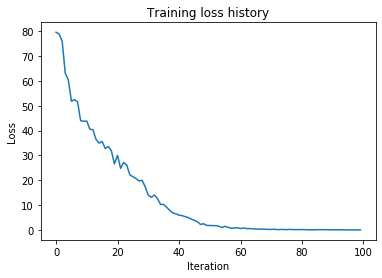

In [8]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples.

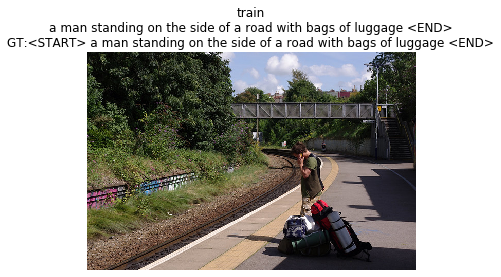

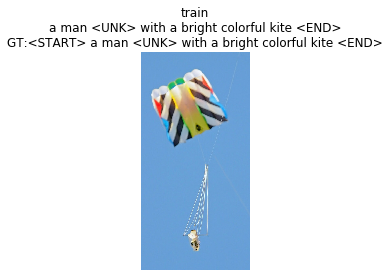

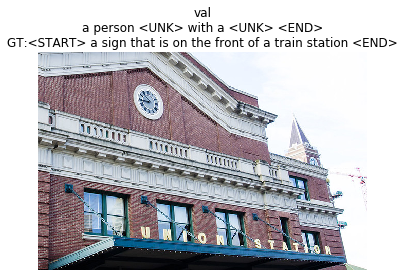

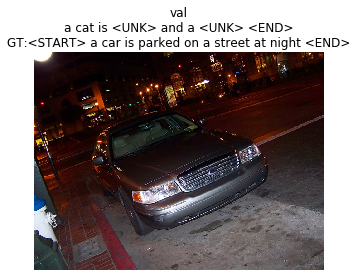

In [9]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# Train a good captioning model (extra credit for 4803)
Using the pieces you have implemented in this and the previous notebook, train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validation set that are better than random.

In addition to qualitatively evaluating your model by inspecting its results, you can also quantitatively evaluate your model using the BLEU unigram precision metric. In order to achieve full credit you should train a model that achieves a BLEU unigram score of >0.3. BLEU scores range from 0 to 1; the closer to 1, the better. Here's a reference to the [paper](http://www.aclweb.org/anthology/P02-1040.pdf) that introduces BLEU if you're interested in learning more about how it works.

Feel free to use PyTorch for this section if you'd like to train faster on a GPU... though you can definitely get above 0.3 using your Numpy code. We're providing you the evaluation code that is compatible with the Numpy model as defined above... you should be able to adapt it for PyTorch if you go that route.

Create the model in the file `cs231n/classifiers/mymodel.py`. You can base it after the `CaptioningRNN` class. Write a text comment in the delineated cell below explaining what you tried in your model. 

Also add a cell below that trains and tests your model. Make sure to include the call to evaluate_model which prints out your highest validation BLEU score for full credit.

In [12]:
def BLEU_score(gt_caption, sample_caption):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)
    
    print('Average BLEU score: ', BLEUscores)
    
    
#     for split in BLEUscores:
#         print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))
    return BLEUscores

In [13]:
# write a description of your model here:
#For my model, I used the Captioning RNN code with cell type as LSTM, and tried various values for the \
# hyperparameters num_epochs, batch size, learning rate, and lr_decay. The best score was 0.299 for validation.
np.random.seed(231)

data = load_coco_data()



mymodel = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
            dtype=np.float32
        )

mymodel_solver = CaptioningSolver(mymodel, data,
           update_rule='adam',
           num_epochs=5,
           batch_size=128,
           optim_config={
             'learning_rate': 1e-4,
           },
           lr_decay=0.997,
           verbose=True, print_every=100,
            callback=evaluate_model
         )

mymodel_solver.train()

(Iteration 1 / 15630) loss: 76.893172
Average BLEU score:  {'train': 0.007388741105637643, 'val': 0.007157726692209437}
Average BLEU score:  {'train': 0.030048371307388837, 'val': 0.03169793499788517}
Average BLEU score:  {'train': 0.049185979946877185, 'val': 0.05042785862854439}
Average BLEU score:  {'train': 0.07363372420350832, 'val': 0.07370175738146288}
Average BLEU score:  {'train': 0.09595290451924686, 'val': 0.09499026981839805}
Average BLEU score:  {'train': 0.09848533481967278, 'val': 0.10281220057716466}
Average BLEU score:  {'train': 0.10524002334800195, 'val': 0.10437200949775073}
Average BLEU score:  {'train': 0.09794159167288326, 'val': 0.09524922056274973}
Average BLEU score:  {'train': 0.08977924255697511, 'val': 0.09231398305487289}
Average BLEU score:  {'train': 0.07451860149411828, 'val': 0.07718835931885498}
(Iteration 101 / 15630) loss: 58.322045
Average BLEU score:  {'train': 0.13004331560674667, 'val': 0.12700638232584685}
Average BLEU score:  {'train': 0.14153

Average BLEU score:  {'train': 0.1713378374038378, 'val': 0.16605061372572616}
Average BLEU score:  {'train': 0.1844089856824891, 'val': 0.17520850507816807}
(Iteration 1001 / 15630) loss: 38.960217
Average BLEU score:  {'train': 0.17225009877839784, 'val': 0.16121749963871726}
Average BLEU score:  {'train': 0.20352663432720566, 'val': 0.18566228945764804}
Average BLEU score:  {'train': 0.174547696374885, 'val': 0.17421734121654237}
Average BLEU score:  {'train': 0.16801667739289095, 'val': 0.1616023473920176}
Average BLEU score:  {'train': 0.1459396466970529, 'val': 0.1413032955711464}
Average BLEU score:  {'train': 0.173744417169413, 'val': 0.17090244470695076}
Average BLEU score:  {'train': 0.16745443616691505, 'val': 0.16330679925235628}
Average BLEU score:  {'train': 0.15957209264912633, 'val': 0.15950634477538125}
Average BLEU score:  {'train': 0.1901707095149224, 'val': 0.18141367067904898}
Average BLEU score:  {'train': 0.15994820855855957, 'val': 0.15933728453082255}
(Iteratio

Average BLEU score:  {'train': 0.19890097131725634, 'val': 0.19857346572740384}
Average BLEU score:  {'train': 0.19884801563214863, 'val': 0.20183034387173818}
Average BLEU score:  {'train': 0.19571391566738483, 'val': 0.20984361443281174}
(Iteration 2001 / 15630) loss: 33.280607
Average BLEU score:  {'train': 0.17808318283454413, 'val': 0.183538028733687}
Average BLEU score:  {'train': 0.21175170208881658, 'val': 0.21166580662946188}
Average BLEU score:  {'train': 0.1994791850787547, 'val': 0.19728318308001058}
Average BLEU score:  {'train': 0.21103188687860058, 'val': 0.21414485797584076}
Average BLEU score:  {'train': 0.19694926185544728, 'val': 0.1990027655802409}
Average BLEU score:  {'train': 0.2262785050883394, 'val': 0.20998279467417055}
Average BLEU score:  {'train': 0.2202015540292807, 'val': 0.22756875824683842}
Average BLEU score:  {'train': 0.20805266202722147, 'val': 0.21456940921996576}
Average BLEU score:  {'train': 0.1982924456083548, 'val': 0.1975522052966103}
Average

Average BLEU score:  {'train': 0.24053722888405232, 'val': 0.24049847468053698}
Average BLEU score:  {'train': 0.23106568591818102, 'val': 0.21306241856233302}
Average BLEU score:  {'train': 0.2422522395847554, 'val': 0.22687692999904707}
Average BLEU score:  {'train': 0.24279554066769182, 'val': 0.2316769280500307}
(Iteration 3001 / 15630) loss: 32.607295
Average BLEU score:  {'train': 0.22627530533793389, 'val': 0.21907247654101866}
Average BLEU score:  {'train': 0.24544888563565231, 'val': 0.2389641782032859}
Average BLEU score:  {'train': 0.25059928678345106, 'val': 0.23805030148011763}
Average BLEU score:  {'train': 0.23658445390515556, 'val': 0.22044687786573575}
Average BLEU score:  {'train': 0.23882597512849565, 'val': 0.23221175561744872}
Average BLEU score:  {'train': 0.2536275944213835, 'val': 0.23183846708424102}
Average BLEU score:  {'train': 0.22625573557636103, 'val': 0.22879096606022506}
Average BLEU score:  {'train': 0.24435438381453853, 'val': 0.2364295135599277}
Aver

Average BLEU score:  {'train': 0.24592829881679737, 'val': 0.23747364170908253}
Average BLEU score:  {'train': 0.24545108444687191, 'val': 0.245565933254653}
Average BLEU score:  {'train': 0.2456046926711696, 'val': 0.24270057163360292}
Average BLEU score:  {'train': 0.24092056105131518, 'val': 0.23668048187589794}
Average BLEU score:  {'train': 0.25339777581317263, 'val': 0.2411924285167422}
(Iteration 4001 / 15630) loss: 30.584047
Average BLEU score:  {'train': 0.25488119730938347, 'val': 0.24250590786431153}
Average BLEU score:  {'train': 0.25009801164526896, 'val': 0.247614425705882}
Average BLEU score:  {'train': 0.26277622373957144, 'val': 0.2531723533820078}
Average BLEU score:  {'train': 0.25125387149917244, 'val': 0.26175481472528844}
Average BLEU score:  {'train': 0.23715062005779708, 'val': 0.2344374649398355}
Average BLEU score:  {'train': 0.26172627932068243, 'val': 0.25463708708210736}
Average BLEU score:  {'train': 0.25536873919573283, 'val': 0.2522322945459151}
Average 

Average BLEU score:  {'train': 0.2516309832011458, 'val': 0.2547263527983986}
Average BLEU score:  {'train': 0.2662298568139074, 'val': 0.2534510456176228}
Average BLEU score:  {'train': 0.2694488997499612, 'val': 0.2516441288038126}
Average BLEU score:  {'train': 0.24532933626264297, 'val': 0.24380671724145583}
Average BLEU score:  {'train': 0.26701457412102464, 'val': 0.25183723966893307}
Average BLEU score:  {'train': 0.2702221153205404, 'val': 0.2611717125600266}
(Iteration 5001 / 15630) loss: 29.034506
Average BLEU score:  {'train': 0.27119261488939794, 'val': 0.2592420660577913}
Average BLEU score:  {'train': 0.2546034033912014, 'val': 0.24201172116845046}
Average BLEU score:  {'train': 0.26576029185146655, 'val': 0.24654592603558126}
Average BLEU score:  {'train': 0.2730076619506732, 'val': 0.262676894811545}
Average BLEU score:  {'train': 0.2616851380245422, 'val': 0.2626087934949558}
Average BLEU score:  {'train': 0.2748930440570008, 'val': 0.25713033164795135}
Average BLEU sc

Average BLEU score:  {'train': 0.2627555153083942, 'val': 0.26163835280559283}
Average BLEU score:  {'train': 0.2840562285963264, 'val': 0.260014275238658}
Average BLEU score:  {'train': 0.25977197404138763, 'val': 0.25193324638678444}
Average BLEU score:  {'train': 0.2705526084657219, 'val': 0.2677778118713808}
Average BLEU score:  {'train': 0.2731837513189472, 'val': 0.2570212086722094}
Average BLEU score:  {'train': 0.27476148421351604, 'val': 0.25466210332352573}
Average BLEU score:  {'train': 0.2814809686803225, 'val': 0.2662073146882088}
(Iteration 6001 / 15630) loss: 29.215538
Average BLEU score:  {'train': 0.26297230242674047, 'val': 0.25534480992112046}
Average BLEU score:  {'train': 0.26790233478879005, 'val': 0.255620279008962}
Average BLEU score:  {'train': 0.2651723600864174, 'val': 0.2685479051066353}
Average BLEU score:  {'train': 0.25133043512843717, 'val': 0.26176860840289}
Average BLEU score:  {'train': 0.2699987857615424, 'val': 0.2608281873807494}
Average BLEU score

Average BLEU score:  {'train': 0.28192898614424394, 'val': 0.2601534727534907}
Average BLEU score:  {'train': 0.28182168657978846, 'val': 0.2719739018194899}
Average BLEU score:  {'train': 0.2731898261627088, 'val': 0.25784959853918493}
Average BLEU score:  {'train': 0.2754200581377385, 'val': 0.26581995948233733}
Average BLEU score:  {'train': 0.2890539131961755, 'val': 0.27488861378269625}
Average BLEU score:  {'train': 0.2665534744285748, 'val': 0.2657498368095284}
Average BLEU score:  {'train': 0.2776361967312697, 'val': 0.2613291182548178}
Average BLEU score:  {'train': 0.26861821992179824, 'val': 0.26498369656720133}
(Iteration 7001 / 15630) loss: 27.925628
Average BLEU score:  {'train': 0.2810144185796552, 'val': 0.2645432898041905}
Average BLEU score:  {'train': 0.2760344517233486, 'val': 0.2742654232026463}
Average BLEU score:  {'train': 0.273875896367521, 'val': 0.2630892914147882}
Average BLEU score:  {'train': 0.28091685987003545, 'val': 0.26615256728987985}
Average BLEU sc

Average BLEU score:  {'train': 0.28049177583148877, 'val': 0.2731462434920234}
Average BLEU score:  {'train': 0.2889876886788402, 'val': 0.26856874911668704}
Average BLEU score:  {'train': 0.29625313786884466, 'val': 0.28225192738726645}
Average BLEU score:  {'train': 0.27736222172746194, 'val': 0.27726001345924406}
Average BLEU score:  {'train': 0.27886538322935644, 'val': 0.26603846656156177}
Average BLEU score:  {'train': 0.27190502897683044, 'val': 0.26428704455500657}
Average BLEU score:  {'train': 0.2764284055928894, 'val': 0.26766018940069025}
Average BLEU score:  {'train': 0.2706636113545286, 'val': 0.2692694236461253}
Average BLEU score:  {'train': 0.2988965779525077, 'val': 0.2697005640650951}
(Iteration 8001 / 15630) loss: 27.348087
Average BLEU score:  {'train': 0.28865673584689294, 'val': 0.26427964261440534}
Average BLEU score:  {'train': 0.2750122740373007, 'val': 0.2685138899457246}
Average BLEU score:  {'train': 0.28109194266639853, 'val': 0.26814600612510026}
Average 

Average BLEU score:  {'train': 0.2912047127468214, 'val': 0.28193438778674357}
Average BLEU score:  {'train': 0.28653831486109965, 'val': 0.2736384295499482}
Average BLEU score:  {'train': 0.28297931010132343, 'val': 0.26271915756178144}
Average BLEU score:  {'train': 0.2856204505786307, 'val': 0.2805782917430802}
Average BLEU score:  {'train': 0.280284190962461, 'val': 0.2685149495285984}
Average BLEU score:  {'train': 0.2809524864484798, 'val': 0.2698232645422677}
Average BLEU score:  {'train': 0.2794638524698975, 'val': 0.27744853231344263}
Average BLEU score:  {'train': 0.2802718445941252, 'val': 0.2612067310098315}
Average BLEU score:  {'train': 0.299160484440929, 'val': 0.27460207215224136}
Average BLEU score:  {'train': 0.28777805764655723, 'val': 0.27611146381695134}
(Iteration 9001 / 15630) loss: 26.718017
Average BLEU score:  {'train': 0.28638768864192293, 'val': 0.27364072535793743}
Average BLEU score:  {'train': 0.29211476262810276, 'val': 0.26524635929263457}
Average BLEU 

(Iteration 9901 / 15630) loss: 26.918962
Average BLEU score:  {'train': 0.2809299002585605, 'val': 0.27027867344337586}
Average BLEU score:  {'train': 0.2894443646863523, 'val': 0.27278775263842103}
Average BLEU score:  {'train': 0.29953346941579756, 'val': 0.2798602948562969}
Average BLEU score:  {'train': 0.2874382632214743, 'val': 0.27659836435094876}
Average BLEU score:  {'train': 0.2968692635210813, 'val': 0.28373017664303934}
Average BLEU score:  {'train': 0.28351293666486105, 'val': 0.2776491223850068}
Average BLEU score:  {'train': 0.28740802805079185, 'val': 0.2704628788373754}
Average BLEU score:  {'train': 0.29359032805980717, 'val': 0.290611283691875}
Average BLEU score:  {'train': 0.27953506551220164, 'val': 0.26774354666091965}
Average BLEU score:  {'train': 0.2848165261167154, 'val': 0.2709978686284771}
(Iteration 10001 / 15630) loss: 26.872456
Average BLEU score:  {'train': 0.29614894673141606, 'val': 0.27748026227859857}
Average BLEU score:  {'train': 0.291717683903305

Average BLEU score:  {'train': 0.29054209406836284, 'val': 0.27986422476872924}
(Iteration 10901 / 15630) loss: 25.187453
Average BLEU score:  {'train': 0.2917718061983754, 'val': 0.267066564402908}
Average BLEU score:  {'train': 0.28001652693588175, 'val': 0.2727154006639922}
Average BLEU score:  {'train': 0.29424736429922155, 'val': 0.28397417985949847}
Average BLEU score:  {'train': 0.28762585720581746, 'val': 0.2716868050797375}
Average BLEU score:  {'train': 0.2926052033666382, 'val': 0.27180030103961444}
Average BLEU score:  {'train': 0.29395307149596095, 'val': 0.28730113303183097}
Average BLEU score:  {'train': 0.28958204437204904, 'val': 0.28103981625022334}
Average BLEU score:  {'train': 0.2878772328631896, 'val': 0.2658486634358483}
Average BLEU score:  {'train': 0.2848291921094942, 'val': 0.26551419889062067}
Average BLEU score:  {'train': 0.290499755258668, 'val': 0.27025039252566296}
(Iteration 11001 / 15630) loss: 26.652392
Average BLEU score:  {'train': 0.29917833772911

Average BLEU score:  {'train': 0.2985606900008828, 'val': 0.27212367702777335}
Average BLEU score:  {'train': 0.29989262720174426, 'val': 0.27552389685792766}
(Iteration 11901 / 15630) loss: 26.735719
Average BLEU score:  {'train': 0.2964988557243452, 'val': 0.27781676076362016}
Average BLEU score:  {'train': 0.29725376874599724, 'val': 0.26309357274115985}
Average BLEU score:  {'train': 0.2914795441410862, 'val': 0.2792535791436657}
Average BLEU score:  {'train': 0.28803155780425643, 'val': 0.26842056799472425}
Average BLEU score:  {'train': 0.2893403638859798, 'val': 0.2683114646993221}
Average BLEU score:  {'train': 0.2876061617774762, 'val': 0.2639620773400341}
Average BLEU score:  {'train': 0.29422108957113274, 'val': 0.2780671989305468}
Average BLEU score:  {'train': 0.300734498397306, 'val': 0.2870245740212245}
Average BLEU score:  {'train': 0.2953379731550166, 'val': 0.27628783725587114}
Average BLEU score:  {'train': 0.3082021662479058, 'val': 0.2779619274733924}
(Iteration 12

Average BLEU score:  {'train': 0.2928932661088108, 'val': 0.28156828181190446}
Average BLEU score:  {'train': 0.2807318236777403, 'val': 0.26888276116010223}
Average BLEU score:  {'train': 0.29329185203830316, 'val': 0.2724831465823244}
(Iteration 12901 / 15630) loss: 25.309593
Average BLEU score:  {'train': 0.28921235496414255, 'val': 0.26952664642479}
Average BLEU score:  {'train': 0.2901349651410661, 'val': 0.2759013032389971}
Average BLEU score:  {'train': 0.30125178887469456, 'val': 0.2859631348114433}
Average BLEU score:  {'train': 0.2925491516705342, 'val': 0.2797140850470986}
Average BLEU score:  {'train': 0.3072228430414646, 'val': 0.2915598300598257}
Average BLEU score:  {'train': 0.3102298249684943, 'val': 0.2812361741622627}
Average BLEU score:  {'train': 0.30022121328166523, 'val': 0.27437252450077193}
Average BLEU score:  {'train': 0.3021288732059554, 'val': 0.2818043925190926}
Average BLEU score:  {'train': 0.29941197515861545, 'val': 0.28741414128995935}
Average BLEU sc

Average BLEU score:  {'train': 0.3121743684369517, 'val': 0.29110867040503946}
Average BLEU score:  {'train': 0.30443498645019684, 'val': 0.2814671812691251}
Average BLEU score:  {'train': 0.30206706587454973, 'val': 0.27619356929157185}
Average BLEU score:  {'train': 0.2929411606653931, 'val': 0.2911251080001102}
(Iteration 13901 / 15630) loss: 26.933112
Average BLEU score:  {'train': 0.28975478330416704, 'val': 0.2747115355377925}
Average BLEU score:  {'train': 0.30523197520068657, 'val': 0.2878680119625106}
Average BLEU score:  {'train': 0.2941407405114995, 'val': 0.2754594648634082}
Average BLEU score:  {'train': 0.2973336996195287, 'val': 0.2710095135774183}
Average BLEU score:  {'train': 0.30625808491333534, 'val': 0.28631136596996715}
Average BLEU score:  {'train': 0.3063087188646189, 'val': 0.29071132232788777}
Average BLEU score:  {'train': 0.3045935296435107, 'val': 0.2892184427438555}
Average BLEU score:  {'train': 0.31432509629262295, 'val': 0.28623082630456764}
Average BLE

Average BLEU score:  {'train': 0.3053945276507626, 'val': 0.29797968036002287}
Average BLEU score:  {'train': 0.3074947377115143, 'val': 0.28253724342732145}
Average BLEU score:  {'train': 0.30102878126128546, 'val': 0.28985585117638946}
Average BLEU score:  {'train': 0.29935027524179336, 'val': 0.29926545254174836}
Average BLEU score:  {'train': 0.3152121666723409, 'val': 0.2865878040936258}
(Iteration 14901 / 15630) loss: 25.864453
Average BLEU score:  {'train': 0.3039982255467448, 'val': 0.284741787116952}
Average BLEU score:  {'train': 0.301739421606317, 'val': 0.28779115070314926}
Average BLEU score:  {'train': 0.3019236056487972, 'val': 0.27592592583788794}
Average BLEU score:  {'train': 0.299070764310927, 'val': 0.27359588098888493}
Average BLEU score:  {'train': 0.29542200975847377, 'val': 0.2740154094918624}
Average BLEU score:  {'train': 0.30203432071252445, 'val': 0.27850801160679933}
Average BLEU score:  {'train': 0.3040482575140315, 'val': 0.2781297908642601}
Average BLEU 

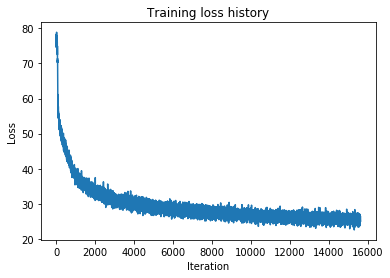

In [14]:
# Plot the training losses
plt.plot(mymodel_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [15]:
# write your code to train your model here.
# make sure to include the call to evaluate_model which prints out your highest validation BLEU score.
print('Best Iteration:', mymodel_solver.best_iterations)
# evaluate_model(mymodel_solver.best_model)

Best Iteration: 14820


In [16]:
mymodel_solver.best_score

0.29953151893601404